Week 11 · Day 6 — RNN vs Attention on Toy Sequences
Why this matters

RNNs process tokens sequentially, which makes them slow and prone to losing long-range dependencies. Attention looks at the whole sequence at once, making it parallelizable and better at capturing long-term relationships. Today you’ll see this difference on a toy problem.

Theory Essentials

RNN: hidden state passes info step by step → struggles with long sequences.

Attention: every token attends to all tokens simultaneously.

Toy task example: “copy the input” or “pick the max token” → easy for attention, harder for RNN.

Main comparison: training speed, accuracy, and ability to model long dependencies.

In [2]:
# Setup
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(42)

# --- Toy dataset: sequences of numbers, predict the sum of the sequence ---
def make_data(n_samples=2000, seq_len=10):
    X = torch.randint(0,10,(n_samples,seq_len)).float()
    y = X.sum(dim=1, keepdim=True)  # target is sum
    return X, y

X, y = make_data()

train_X, test_X = X[:1500], X[1500:]
train_y, test_y = y[:1500], y[1500:]

# --- RNN baseline ---
class RNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden=32):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        x = x.unsqueeze(-1)  # (B,L,1)
        _, h = self.rnn(x)
        return self.fc(h.squeeze(0))

# --- Attention baseline ---
class AttentionModel(nn.Module):
    def __init__(self, d_model=32):
        super().__init__()
        self.embed = nn.Linear(1,d_model)
        self.attn = nn.MultiheadAttention(d_model, num_heads=4, batch_first=True)
        self.fc = nn.Linear(d_model,1)
    def forward(self,x):
        x = self.embed(x.unsqueeze(-1))  # (B,L,d_model)
        out,_ = self.attn(x,x,x)         # self-attention
        return self.fc(out.mean(dim=1))  # mean pooling

# Training loop
def train(model, X, y, epochs=100):
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        pred = model(X)
        loss = F.mse_loss(pred, y)
        opt.zero_grad(); loss.backward(); opt.step()
    return loss.item()

rnn = RNNModel()
attn = AttentionModel()

print("RNN loss:", train(rnn, train_X, train_y))
print("Attention loss:", train(attn, train_X, train_y))

# Evaluate
with torch.no_grad():
    rnn_pred = rnn(test_X)
    attn_pred = attn(test_X)
print("RNN test MSE:", F.mse_loss(rnn_pred,test_y).item())
print("Attention test MSE:", F.mse_loss(attn_pred,test_y).item())


RNN loss: 332.4309997558594
Attention loss: 10.429502487182617
RNN test MSE: 294.930419921875
Attention test MSE: 9.564870834350586


Attention is much better

1) Core (10–15 min)
Task: Increase sequence length from 10 → 30. Which model struggles more?

In [3]:
X,y = make_data(seq_len=30)
rnn = RNNModel(); attn = AttentionModel()
print("RNN:", train(rnn,X,y))
print("Attn:", train(attn,X,y))


RNN: 10531.7373046875
Attn: 123.99821472167969


2) Practice (10–15 min)
Task: Change the toy task: instead of sum, predict the maximum token.

In [ ]:
X_ = torch.randint(0,10,(2000,20)).float()
y_ = X.max(dim=1, keepdim=True).values
rnn = RNNModel(); attn = AttentionModel()
print("RNN:", train(rnn,X_,y_))
print("Attn:", train(attn,X_,y_))


RNN: 0.12469485402107239
Attn: 0.007119511254131794


3) Stretch (optional, 10–15 min)
Task: Visualize training loss over epochs for both models.

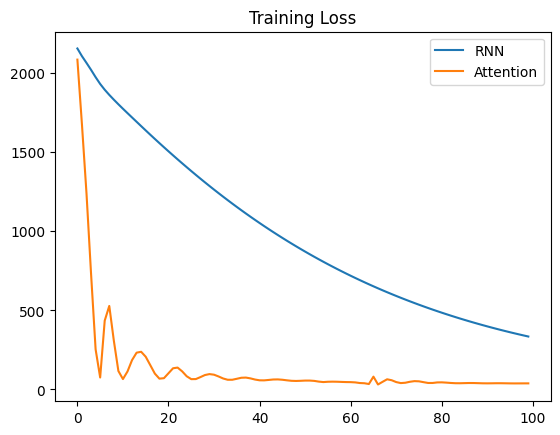

In [6]:
def train_curve(model,X,y,epochs=100):
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    losses=[]
    for e in range(epochs):
        pred=model(X)
        loss=F.mse_loss(pred,y)
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())
    return losses

loss_rnn=train_curve(RNNModel(),train_X,train_y)
loss_attn=train_curve(AttentionModel(),train_X,train_y)

plt.plot(loss_rnn,label="RNN")
plt.plot(loss_attn,label="Attention")
plt.legend(); plt.title("Training Loss")
plt.show()


Mini-Challenge (≤40 min)

Build: A notebook comparing RNN vs Attention on at least 2 toy tasks (sum, max).
Acceptance Criteria:

Both models implemented and trained.

Test losses reported.

Short note: which task is harder for RNNs, and why attention wins.

In [7]:
# Mini-Challenge: RNN vs Attention on SUM and MAX
# ------------------------------------------------
# Setup
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(42)

device = "cpu"

# ----- Data generators -----
def make_sum_data(n_samples=2000, seq_len=10):
    X = torch.randint(0, 10, (n_samples, seq_len)).float()
    y = X.sum(dim=1, keepdim=True)
    return X.to(device), y.to(device)

def make_max_data(n_samples=2000, seq_len=10):
    X = torch.randint(0, 10, (n_samples, seq_len)).float()
    y = X.max(dim=1, keepdim=True).values
    return X.to(device), y.to(device)

def train_test_split(X, y, n_train=1500):
    return X[:n_train], X[n_train:], y[:n_train], y[n_train:]

# ----- Models -----
class RNNModel(nn.Module):
    """Fair baseline: pool over ALL time steps (not just last state)."""
    def __init__(self, input_dim=1, hidden=64, cell="GRU"):
        super().__init__()
        rnn_cls = {"RNN": nn.RNN, "GRU": nn.GRU, "LSTM": nn.LSTM}[cell]
        self.cell_type = cell
        self.rnn = rnn_cls(input_dim, hidden, batch_first=True)
        self.fc  = nn.Linear(hidden, 1)
    def forward(self, x):
        x = x.unsqueeze(-1)                 # (B, L, 1)
        out, _ = self.rnn(x)                # (B, L, H)
        out = out.mean(dim=1)               # simple pooling over time
        return self.fc(out)

class AttentionModel(nn.Module):
    """1-layer MHA + mean pooling."""
    def __init__(self, d_model=64, n_heads=4):
        super().__init__()
        self.embed = nn.Linear(1, d_model)
        self.attn  = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.fc    = nn.Linear(d_model, 1)
    def forward(self, x):
        x = self.embed(x.unsqueeze(-1))     # (B, L, d)
        out, _ = self.attn(x, x, x)         # self-attention (no masks needed)
        out = out.mean(dim=1)               # global pooling
        return self.fc(out)

# ----- Training -----
def train(model, X, y, epochs=120, lr=1e-3):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for _ in range(epochs):
        pred = model(X)
        loss = F.mse_loss(pred, y)
        opt.zero_grad(); loss.backward(); opt.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, X, y):
    model.eval()
    pred = model(X)
    return F.mse_loss(pred, y).item()

def run_task(make_data_fn, name):
    X, y = make_data_fn()
    trX, teX, trY, teY = train_test_split(X, y)

    rnn = RNNModel(cell="GRU").to(device)
    att = AttentionModel().to(device)

    rnn_train_loss = train(rnn, trX, trY, epochs=150, lr=3e-3)
    att_train_loss = train(att, trX, trY, epochs=150, lr=3e-3)

    rnn_test = evaluate(rnn, teX, teY)
    att_test = evaluate(att, teX, teY)

    print(f"\n=== {name} task ===")
    print(f"RNN train loss:      {rnn_train_loss:.4f}")
    print(f"Attention train loss:{att_train_loss:.4f}")
    print(f"RNN test MSE:        {rnn_test:.4f}")
    print(f"Attention test MSE:  {att_test:.4f}")
    return {"rnn": rnn_test, "att": att_test}

# ----- Run both tasks -----
sum_results = run_task(make_sum_data, "SUM")
max_results = run_task(make_max_data, "MAX")

# ----- Short note (prints once) -----
note = """
Notes:
• SUM is a global, order-invariant function. Attention + mean-pooling can learn a near-uniform weighting
  (then the linear head maps mean→sum), so it fits very easily. An RNN must compress the whole sequence
  through recurrence; pooling helps, but optimization is harder.
• MAX requires picking the single largest token. Self-attention can learn a peaked distribution that focuses
  on the max position before pooling; a pooled RNN can also learn it, but tends to be slower/sensitive since
  the signal can be diluted across many steps.
"""
print(note)



=== SUM task ===
RNN train loss:      369.0475
Attention train loss:6.7670
RNN test MSE:        331.5301
Attention test MSE:  6.4006

=== MAX task ===
RNN train loss:      0.6388
Attention train loss:0.0023
RNN test MSE:        0.5472
Attention test MSE:  0.0021

Notes:
• SUM is a global, order-invariant function. Attention + mean-pooling can learn a near-uniform weighting
  (then the linear head maps mean→sum), so it fits very easily. An RNN must compress the whole sequence
  through recurrence; pooling helps, but optimization is harder.
• MAX requires picking the single largest token. Self-attention can learn a peaked distribution that focuses
  on the max position before pooling; a pooled RNN can also learn it, but tends to be slower/sensitive since
  the signal can be diluted across many steps.



Notes / Key Takeaways

RNNs = sequential, harder to scale, bad with long dependencies.

Attention = parallel, better at long-range relationships.

On toy tasks, attention is faster and more accurate.

Visualization helps compare learning curves.

This intuition scales up to real NLP tasks (translation, summarization).

Reflection

Why do RNNs struggle as sequence length grows?

How does attention allow direct connections between distant tokens?

Why do RNNs struggle as sequence length grows?
RNNs process tokens one step at a time, passing information through hidden states. As sequences get longer, signals from early tokens fade (vanishing gradients) or get overwritten, making it hard to retain long-range dependencies. This sequential nature also slows training since steps cannot be parallelized.

How does attention allow direct connections between distant tokens?
In self-attention, each token can attend to all others in a single layer by computing similarities (Q·Kᵀ). This creates direct shortcuts between distant positions—“pizza” at position 2 can directly connect to “delicious” at position 50—without needing to propagate step by step. It also allows parallel computation, making it more efficient.